In [ ]:
#!sudo add-apt-repository ppa:ubuntugis/ppa -y
#!sudo apt-get update
#!sudo apt-get install python-numpy gdal-bin libgdal-dev
!pip install pyopencl
!pip install bfast
!pip install rasterio
!pip install PyAstronomy[occult]

In [3]:
import bfast
import rasterio
from osgeo import gdal
import numpy
from datetime import datetime
from PyAstronomy import pyasl
import bisect

In [1]:
import tensorflow
tensorflow.test.gpu_device_name()

''

In [ ]:
#Steps
#1. Download data using gee to gdrive/cloud
# done see Phd:Paper1/download_3
#2. Access Data in google colab
# done
#3. Run bfast and the other algorithm at native resolution
#4. Record run time at native resolution
#5. Run bfast and the other algorithm at each lower resolution, using each downsampling method, i.e. random, central, mean, novel
#6. Only actually run the mean, and just the downsample on native output for the others
#7. Calculate and record accuracies for each method and resolution
#8. When it works, do the same on google cloud (AI platform Notebook) with a specific VM
#9. Analyze the results in R on your own computer

In [43]:
from rasterio.enums import Resampling
downscale_factor = 2
ifile = '/content/drive/MyDrive/Paper1/brazil_small-NDMI-100-2868_5-1300_5-EPSG32619-2010-10-01-2020-01-01-fc2015-maxCloud50-minValid30.tif'
with rasterio.open(ifile) as timeSeries:
  # resample data to target shape
  ndTimeSeries = timeSeries.read(
      out_shape=(
          timeSeries.count,
          int(timeSeries.height / downscale_factor),
          int(timeSeries.width / downscale_factor)
      ),
      resampling=Resampling['average']
  )
  # scale image transform
  transform = timeSeries.transform * timeSeries.transform.scale(
    (timeSeries.width // ndTimeSeries.shape[-1]),
    (timeSeries.height // ndTimeSeries.shape[-2])
  )

In [41]:
print(ndTimeSeries.shape)
print(transform)
print(timeSeries.transform)

(100, 50, 50)
| 60.00, 0.00, 493140.00|
| 0.00,-60.00,-1206900.00|
| 0.00, 0.00, 1.00|
| 30.00, 0.00, 493140.00|
| 0.00,-30.00,-1206900.00|
| 0.00, 0.00, 1.00|


In [ ]:
timeSeries = rasterio.open('/content/drive/MyDrive/Paper1/brazil_small-NDMI-100-2868_5-1300_5-EPSG32619-2010-10-01-2020-01-01-fc2015-maxCloud50-minValid30.tif')
ndTimeSeries = timeSeries.read()

In [24]:
dates = [datetime.strptime(date.split('_')[1],'%Y-%m-%d') for date in timeSeries.descriptions]
monitoring_frac_dates = [pyasl.decimalYear(date) for date in monitoring_dates]

In [22]:
from bfast.monitor.utils import crop_data_dates
start_hist = datetime(2010, 1, 1)
start_monitor = datetime(2015, 1, 1)
end_monitor = datetime(2020, 1, 1)
monitoring_dates = dates[bisect.bisect(dates,start_monitor):]
data, dates = crop_data_dates(ndTimeSeries, dates, start_hist, end_monitor)
print("First date: {}".format(dates[0]))
print("Last date: {}".format(dates[-1]))
print("Shape of data array: {}".format(data.shape))

First date: 2010-12-06 00:00:00
Last date: 2019-11-13 00:00:00
Shape of data array: (100, 100, 100)


In [ ]:
from bfast import BFASTMonitor

model = BFASTMonitor(
            start_monitor,
            freq=365,
            k=1,
            hfrac=0.25,
            trend=False,
            level=0.05,
            backend='python'#,
            #device_id=0
        )
model.fit(data, dates, n_chunks=5, nan_value=-32768)

print("Detected breaks")
# -2 corresponds to not enough data for a pixel
# -1 corresponds to "no breaks detected"
# idx with isx>=0 corresponds to the position of the first break
print(model.breaks)

Detected breaks
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [ ]:
model.get_params()

{'backend': 'python',
 'detailed_results': False,
 'device_id': 0,
 'find_magnitudes': True,
 'freq': 365,
 'hfrac': 0.25,
 'k': 1,
 'level': 0.05,
 'period': 10,
 'platform_id': 0,
 'start_monitor': datetime.datetime(2015, 1, 1, 0, 0),
 'trend': False,
 'verbose': 0}

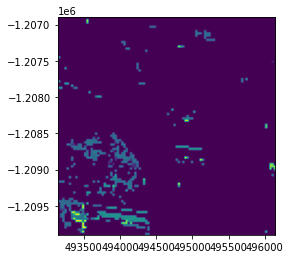

In [ ]:
from matplotlib import pyplot
from rasterio.plot import show
show(model.breaks,transform=timeSeries.transform,cmap="viridis")

In [27]:
def mp(entry):
    return monitoring_frac_dates[int(entry)] if entry >=0 else numpy.nan
mp = numpy.vectorize(mp)
frac_breaks = mp(frac_breaks)
print(frac_)

float64


In [28]:
# niceId-algorithm-method-factor
# e.g. brazil_small-bfastmonitor-control-1
breaks_dataset = rasterio.open(
    './drive/MyDrive/Paper1/brazil_small_100-bfastmonitor_py_frac-control-1.tif',
    'w',
    driver='GTiff',
    height=frac_breaks.shape[0],
    width=frac_breaks.shape[1],
    count=1,
    dtype=frac_breaks.dtype,
    crs=timeSeries.crs,
    transform=timeSeries.transform
    )
breaks_dataset.write(frac_breaks,1)
breaks_dataset.close()

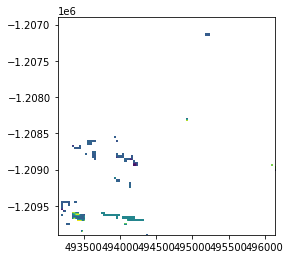

In [26]:
show(frac_breaks,transform=timeSeries.transform,cmap="viridis")